In [ ]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [66]:
import matplotlib.pyplot as plt
import warnings

# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Technical Analysis in Python

## Creating a Candlestick Chart

### Getting ready

1. Import the libraries:

In [ ]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=b65ae5a52853cfcb9f790b7d79436c363e4afadc1d270111fc7a0c6d02c84bf9
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
import pandas as pd 
import yfinance as yf

2. Download the adjusted prices from Yahoo Finance:

In [ ]:
df_twtr = yf.download('TWTR', 
                       start='2018-01-01', 
                       end='2018-12-31',
                       progress=False,
                       auto_adjust=True)
df_twtr

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,24.070000,24.570000,23.850000,24.510000,15297200
2018-01-03,24.559999,24.680000,24.070000,24.450001,12832600
2018-01-04,24.500000,24.590000,23.690001,23.990000,17653500
2018-01-05,24.070000,24.570000,23.879999,24.320000,14953200
2018-01-08,24.370001,24.780001,23.879999,24.590000,17831300
...,...,...,...,...,...
2018-12-21,29.309999,29.760000,27.040001,27.309999,38714100
2018-12-24,26.549999,27.270000,26.260000,26.450001,18208300
2018-12-26,27.000000,28.700001,26.799999,28.660000,35529600


### How to do it...

1. Import the libraries:

In [ ]:
!pip install chart_studio

     |████████████████████████████████| 71kB 3.1MB/s 


In [ ]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

#cf.go_offline()
#init_notebook_mode()

As an alternative to running `cf.go_offline()` every time, we can also modify the settings to always use the offline mode by running: `cf.set_config_file(offline=True)`. We can then view the settings using `cf.get_config_file()`.

2. Create the candlestick chart using Twitter's stock prices:

In [ ]:
qf = cf.QuantFig(df_twtr, title="Twitter's Stock Price", 
                 legend='top', name='TWTR')

3. Add volume and moving averages to the figure:

In [ ]:
qf.add_volume()
qf.add_sma(periods=20, column='Close', color='red')
qf.add_ema(periods=20, color='green') 

4. Display the plot:

In [ ]:
qf.iplot(asFigure=True)

In the plot, we can see that the exponential moving average (EMA) adapts to the
changes in prices much faster than the SMA. Some discontinuities in the chart are
caused by the fact that we are using daily data, and there is no data for
weekends/bank holidays.

## Backtesting a Strategy Based on Simple Moving Average

### How to do it...

#### Signal 

1. Import the libraries:

In [ ]:
!pip install backtrader

     |████████████████████████████████| 419kB 5.4MB/s 


In [ ]:
%matplotlib inline
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt

2. Define a class representing the trading strategy:

For this recipe, we consider a basic strategy based on the SMA. The key points of the
strategy are as follows:
- When the close price becomes higher than the 20-day SMA, buy one share
- When the close price becomes lower than the 20-day SMA and we have a share,
sell it.
- We can only have a maximum of one share at any given time.
- No short selling is allowed.

In [ ]:
class SmaSignal(bt.Signal):
    params = (('period', 20), )
    
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

The signal was built as a class, inheriting from bt.Signal. The signal was represented as a
number—in this case, the difference between the current data point (self.data) and the
moving average (bt.ind.SMA). If the signal is positive, it is an indication to go long (buy).
A negative one indicates short (selling). The value of 0 means there is no signal.

3. Download data from Yahoo Finance:

In [ ]:
data = bt.feeds.YahooFinanceData(dataname='AAPL', 
                                 fromdate=datetime(2018, 1, 1),
                                 todate=datetime(2018, 12, 31))
data

4. Set up the backtest:

In [ ]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

5. Run the backtest:

In [ ]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1011.49


6. Plot the results:

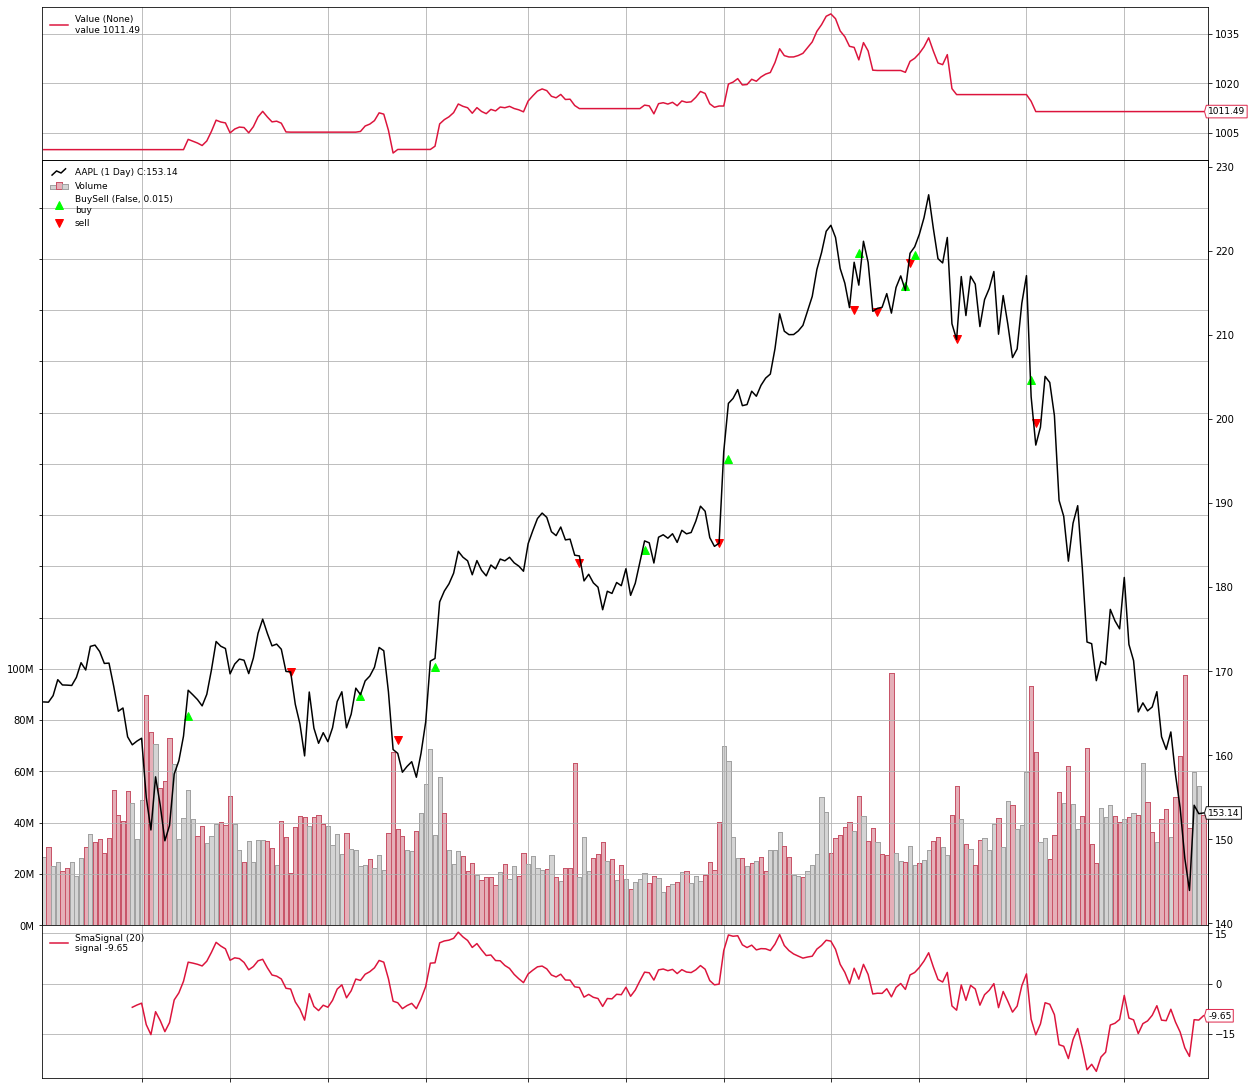

[[<Figure size 1296x1152 with 4 Axes>]]

In [ ]:
#plt.rcParams['font.sans-serif']=['SimHei']
#plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[18, 16]
#plt.rcParams['figure.dpi']=500
#plt.rcParams['figure.facecolor']='w'
#plt.rcParams['figure.edgecolor']='k'
cerebro.plot(iplot=False, volume=True)

#### Strategy

1. The template of the strategy looks like:

In [ ]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

2. Set up the backtest:

In [ ]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

3. Run the backtest:

In [ ]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2018-02-14, BUY CREATED --- Price: 162.29
2018-02-15, BUY EXECUTED --- Price: 164.64, Cost: 164.64, Commission: 0.00
2018-03-19, SELL CREATED --- Price: 169.98
2018-03-20, SELL EXECUTED --- Price: 169.92, Cost: 164.64, Commission: 0.00
2018-03-20, OPERATION RESULT --- Gross: 5.28, Net: 5.28
2018-04-10, BUY CREATED --- Price: 167.99
2018-04-11, BUY EXECUTED --- Price: 167.00, Cost: 167.00, Commission: 0.00
2018-04-20, SELL CREATED --- Price: 160.69
2018-04-23, SELL EXECUTED --- Price: 161.77, Cost: 167.00, Commission: 0.00
2018-04-23, OPERATION RESULT --- Gross: -5.23, Net: -5.23
2018-05-02, BUY CREATED --- Price: 171.21
2018-05-03, BUY EXECUTED --- Price: 170.54, Cost: 170.54, Commission: 0.00
2018-06-15, SELL CREATED --- Price: 183.81
2018-06-18, SELL EXECUTED --- Price: 182.88, Cost: 170.54, Commission: 0.00
2018-06-18, OPERATION RESULT --- Gross: 12.34, Net: 12.34
2018-07-06, BUY CREATED --- Price: 182.97
2018-07-09, BUY EXECUTED --- Price: 184.46, 

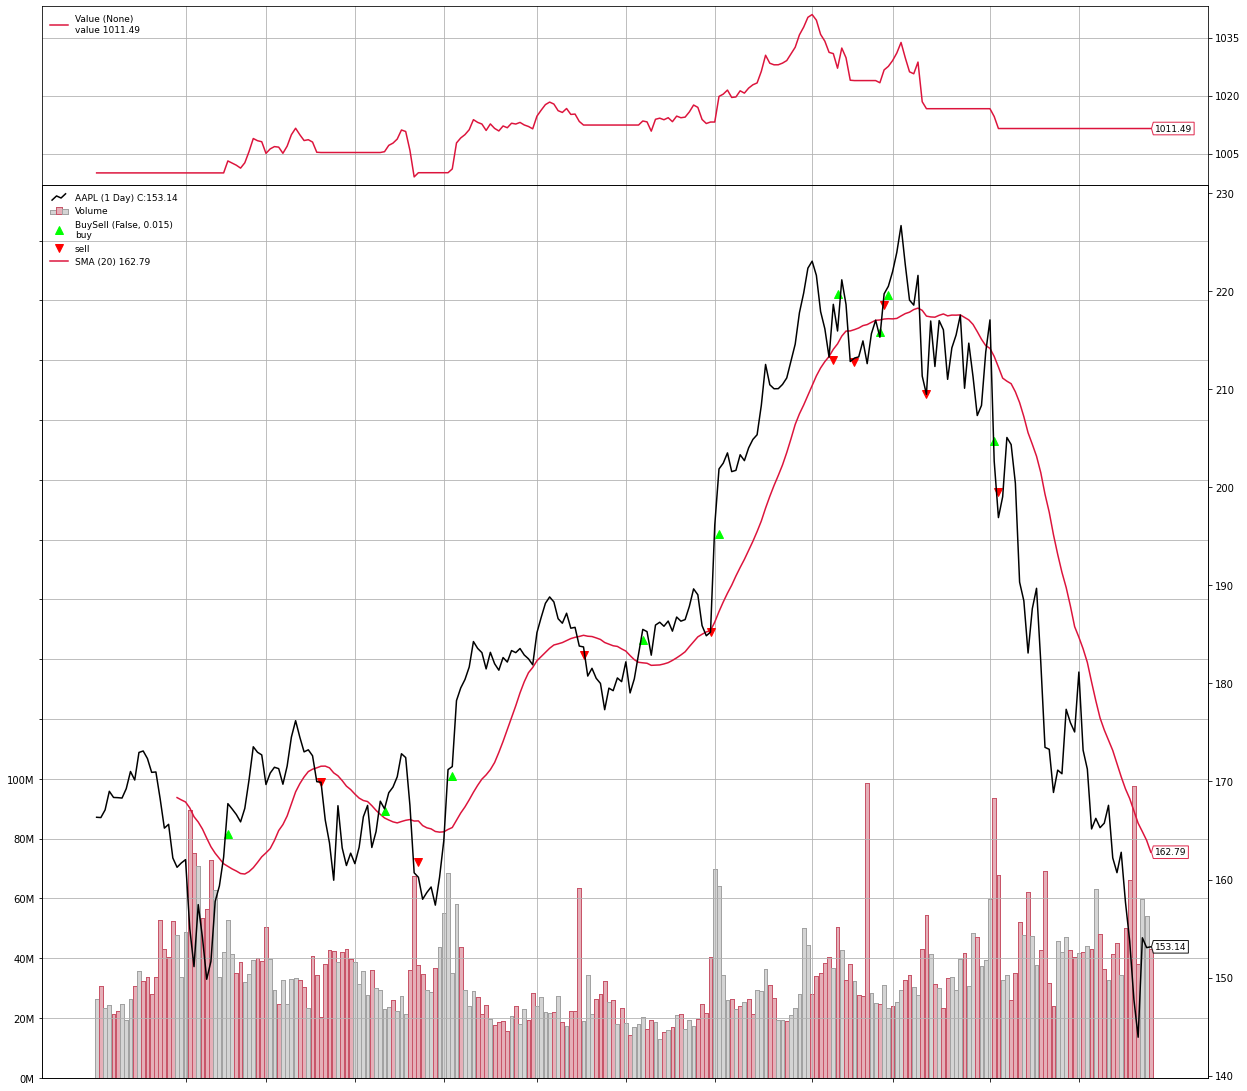

[[<Figure size 1296x1152 with 3 Axes>]]

In [ ]:
cerebro.plot(iplot=False, volume=True)

### There's more

We used the Jupyter magic command `%load` to import the content of the backtrader_sma_strategy_optimization.py file.

In [ ]:
# %load backtrader_sma_strategy_optimization.py
from datetime import datetime
import backtrader as bt

# Create a Stratey
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders
        self.order = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        # set no pending order
        self.order = None

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.order = self.sell()

    def stop(self):
        self.log(f'(ma_period = {self.params.ma_period:2d}) --- Terminal Value: {self.broker.getvalue():.2f}')

# download data
data = bt.feeds.YahooFinanceData(dataname='AAPL',
                                 fromdate=datetime(2018, 1, 1),
                                 todate=datetime(2018, 12, 31))

# create a Cerebro entity
cerebro = bt.Cerebro(stdstats = False)

# set up the backtest
cerebro.adddata(data)
cerebro.optstrategy(SmaStrategy, ma_period=range(10, 31))
cerebro.broker.setcash(1000.0)
cerebro.run(maxcpus=4)


2018-12-28, (ma_period = 11) --- Terminal Value: 1004.31
2018-12-28, (ma_period = 12) --- Terminal Value: 1005.75
2018-12-28, (ma_period = 10) --- Terminal Value: 1006.20
2018-12-28, (ma_period = 13) --- Terminal Value: 992.38
2018-12-28, (ma_period = 14) --- Terminal Value: 977.34
2018-12-28, (ma_period = 15) --- Terminal Value: 981.58
2018-12-28, (ma_period = 17) --- Terminal Value: 992.82
2018-12-28, (ma_period = 16) --- Terminal Value: 979.98
2018-12-28, (ma_period = 20) --- Terminal Value: 1011.49
2018-12-28, (ma_period = 18) --- Terminal Value: 994.84
2018-12-28, (ma_period = 22) --- Terminal Value: 1020.99
2018-12-28, (ma_period = 19) --- Terminal Value: 1005.18
2018-12-28, (ma_period = 21) --- Terminal Value: 1013.48
2018-12-28, (ma_period = 23) --- Terminal Value: 1018.48
2018-12-28, (ma_period = 24) --- Terminal Value: 1018.48
2018-12-28, (ma_period = 25) --- Terminal Value: 1018.00
2018-12-28, (ma_period = 26) --- Terminal Value: 1009.24
2018-12-28, (ma_period = 27) --- Term

[[<backtrader.cerebro.OptReturn at 0x7f21ddea3fd0>],

## Calculating Bollinger Bands and testing a buy/sell strategy

1. Import the libraries:

In [ ]:
import backtrader as bt
import datetime
import pandas as pd
import matplotlib.pyplot as plt

2. The template of the strategy looks like:

In [ ]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], 
                                            period=self.p.period, 
                                            devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], 
                                           self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], 
                                            self.b_band.lines.top)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

3. Download data:

In [ ]:
data = bt.feeds.YahooFinanceData(
    dataname='MSFT',
    fromdate=datetime.datetime(2018, 1, 1),
    todate=datetime.datetime(2018, 12, 31)
)

4. Set up the backtest:

In [ ]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

5. Run the backtest:

In [ ]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2018-02-12, BUY CREATED --- Size: 116, Cash: 10000.00, Open: 85.49, Close: 85.86
2018-02-12, BUY EXECUTED --- Price: 85.49, Cost: 9916.84, Commission: 9.92
2018-04-19, SELL CREATED --- Size: 116
2018-04-19, SELL EXECUTED --- Price: 93.34, Cost: 9916.84, Commission: 10.83
2018-04-19, OPERATION RESULT --- Gross: 910.60, Net: 889.86
2018-06-29, BUY CREATED --- Size: 113, Cash: 10889.86, Open: 96.17, Close: 95.85
2018-06-29, BUY EXECUTED --- Price: 96.17, Cost: 10867.21, Commission: 10.87
2018-07-17, SELL CREATED --- Size: 113
2018-07-17, SELL EXECUTED --- Price: 101.69, Cost: 10867.21, Commission: 11.49
2018-07-17, OPERATION RESULT --- Gross: 623.76, Net: 601.40
2018-10-15, BUY CREATED --- Size: 108, Cash: 11491.26, Open: 106.27, Close: 105.0
2018-10-15, BUY EXECUTED --- Price: 106.27, Cost: 11477.16, Commission: 11.48
Final Portfolio Value: 10627.66


6. Plot the results:

<IPython.core.display.Javascript object>

[[<Figure size 1296x1152 with 4 Axes>]]

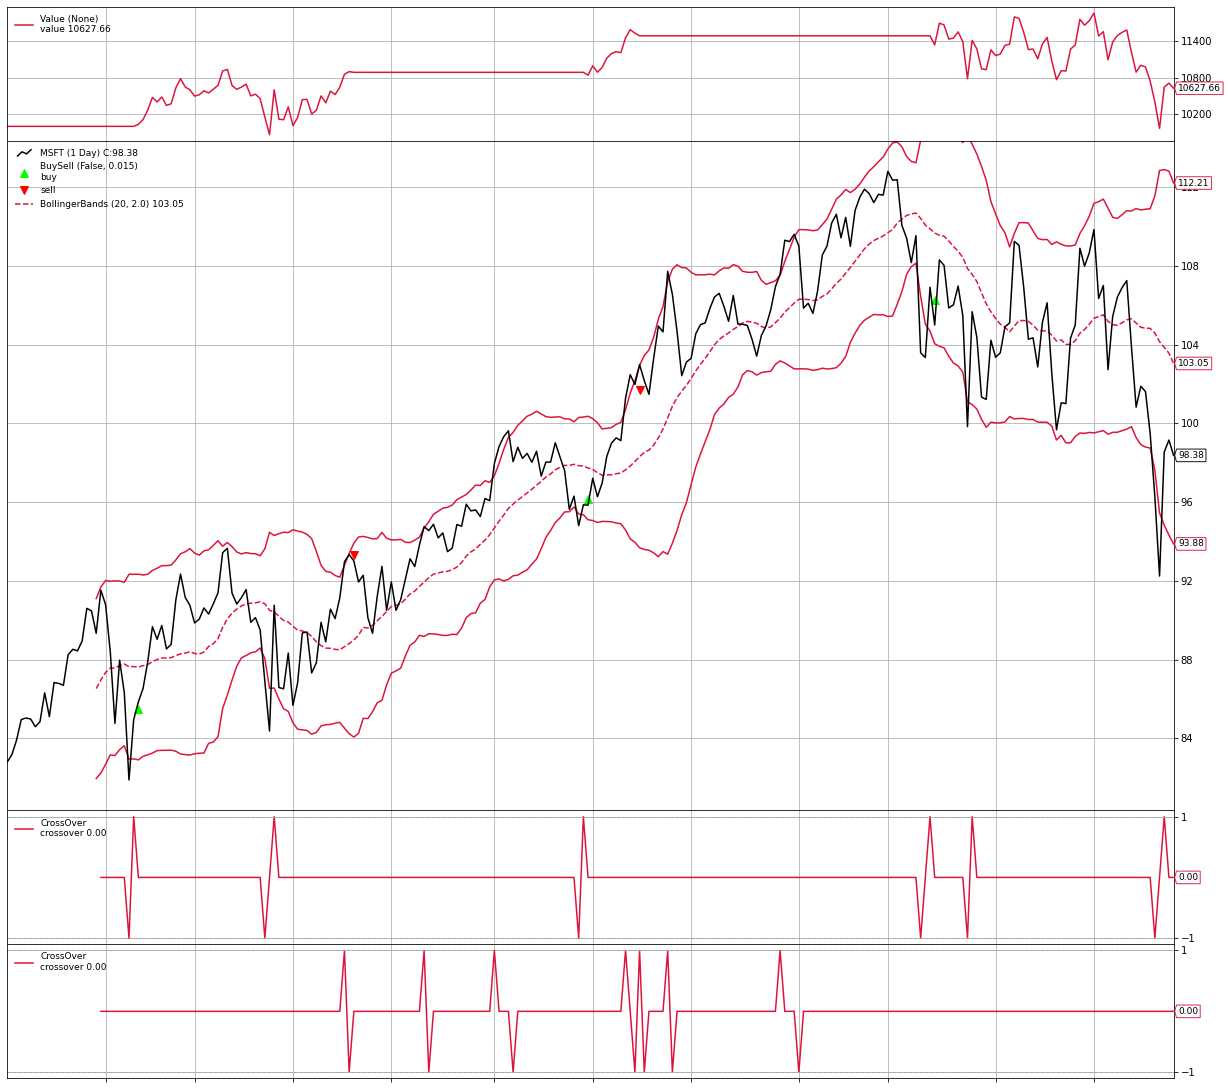

In [ ]:
cerebro.plot(iplot=True, volume=False)

7. Run to investigate different returns metrics:

In [ ]:
print(backtest_result[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', 0.06087497918029678), ('ravg', 0.00024349991672118713), ('rnorm', 0.06328373093144811), ('rnorm100', 6.328373093144811)])


8. Create a plot of daily portfolio returns:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

<IPython.core.display.Javascript object>

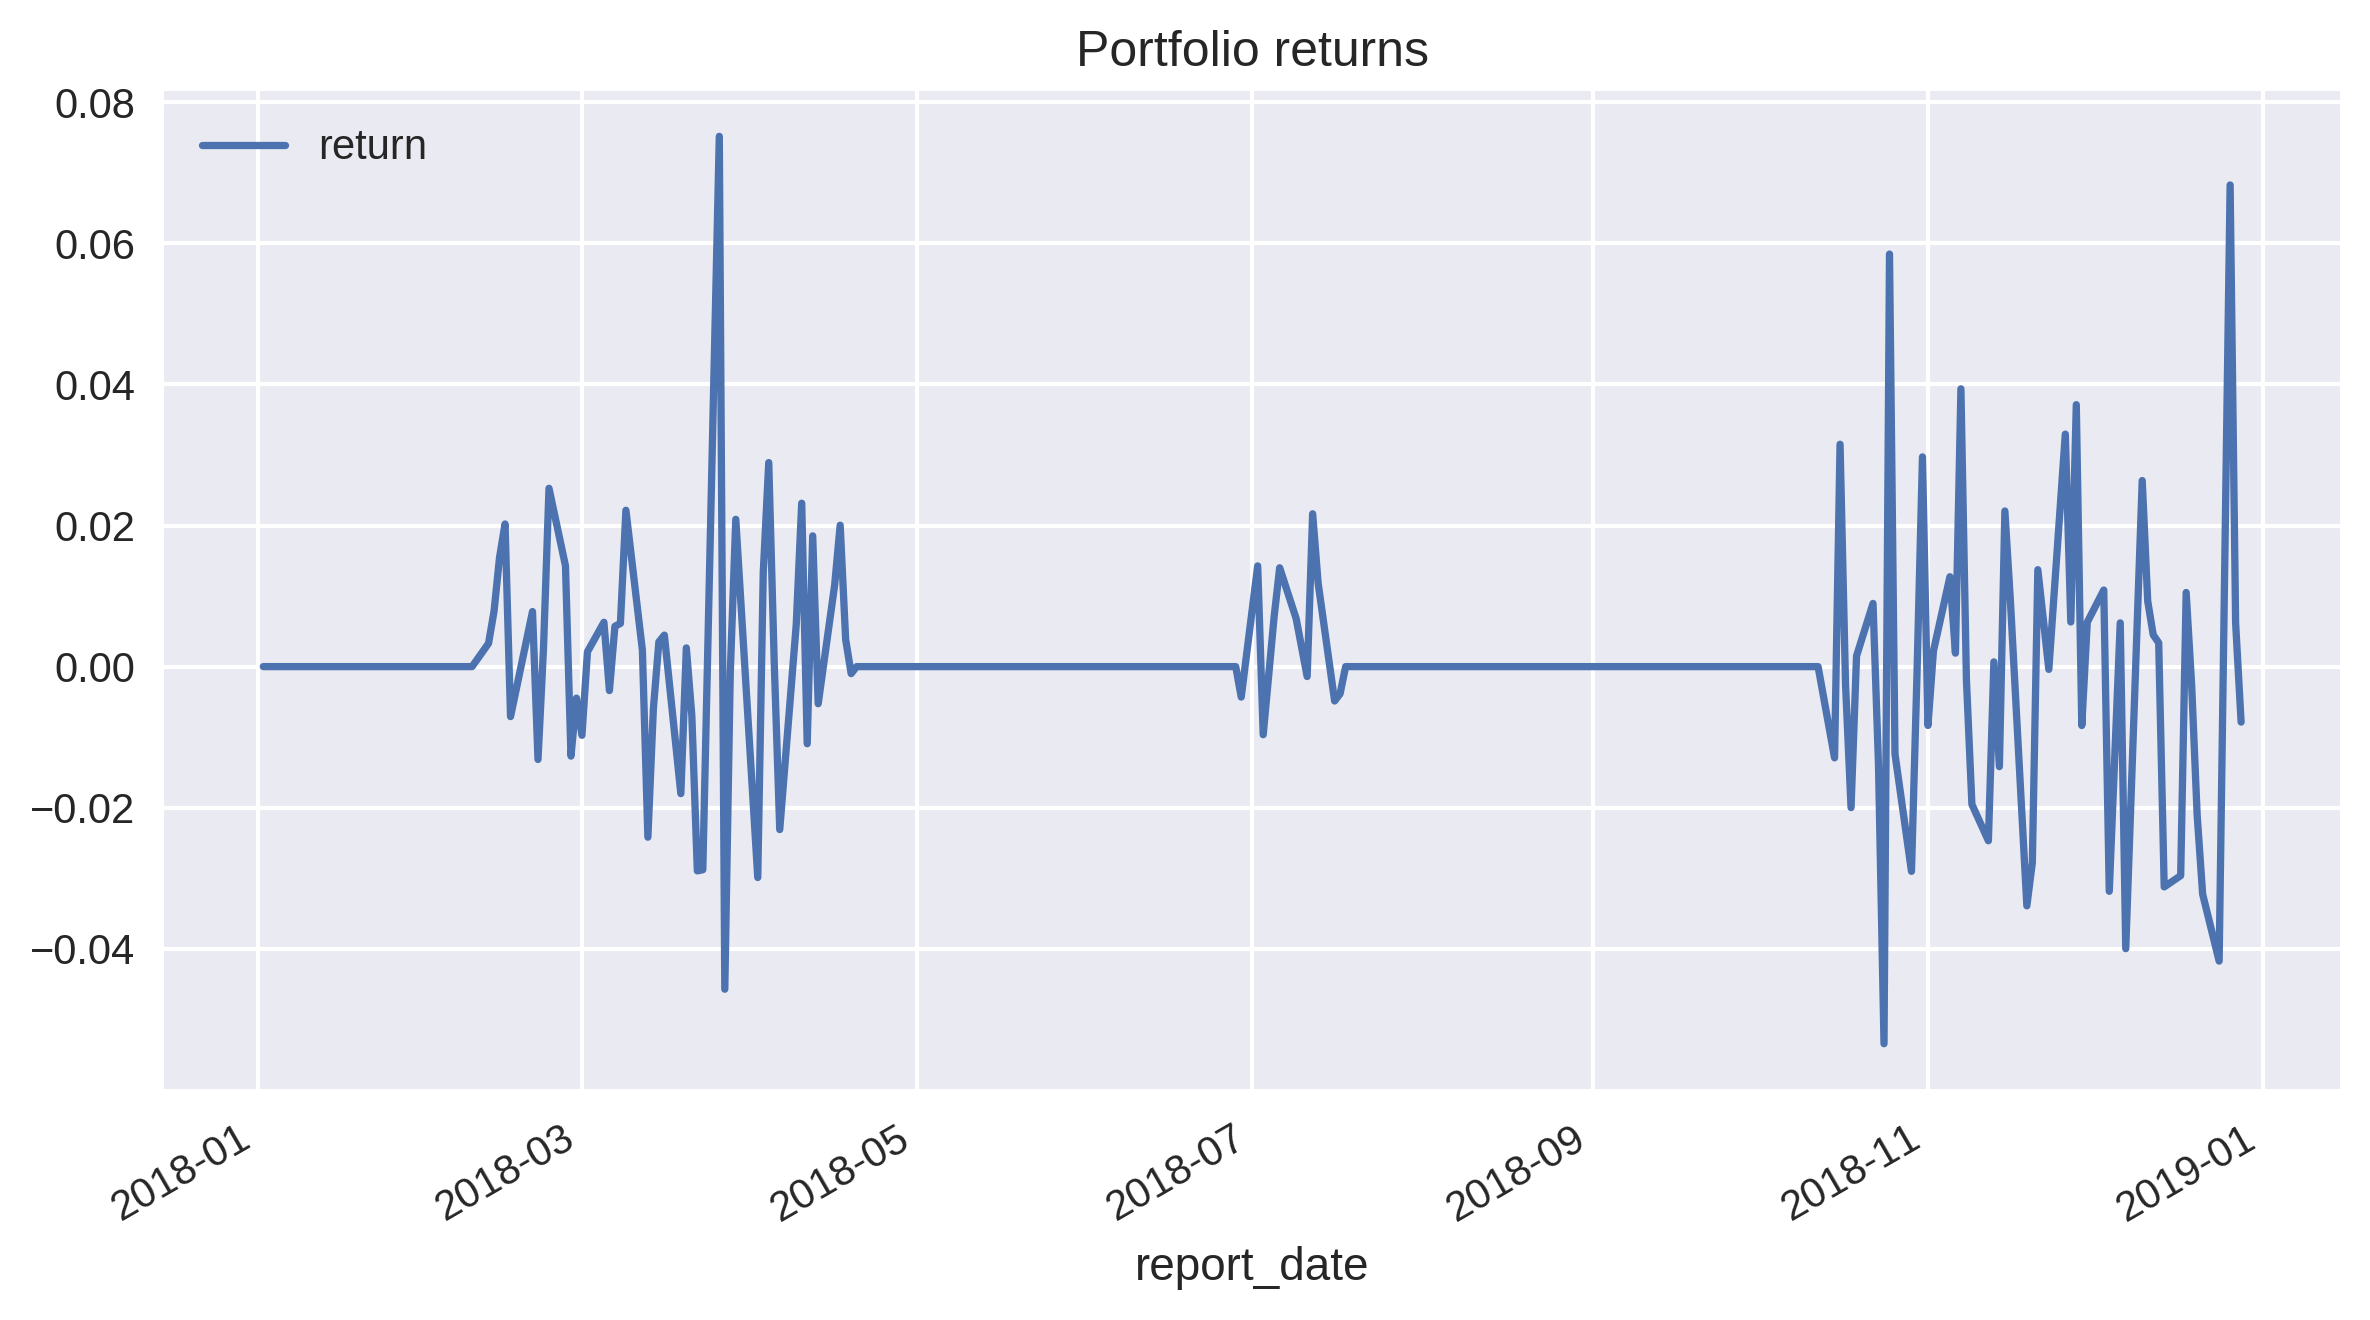

In [ ]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                          columns = ['report_date', 'return']) \
               .set_index('report_date')
returns_df.plot(title='Portfolio returns')

plt.tight_layout()
# plt.savefig('images/ch2_im9.png')
plt.show()

## Calculating the relative strength index and testing a long/short strategy

1. Import the libraries:

In [ ]:
from datetime import datetime
import backtrader as bt

2. Define the signal strategy based on bt.SignalStrategy:

In [ ]:
# create a Stratey
class RsiSignalStrategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70, 
                  rsi_lower=30, rsi_mid=50)

    def __init__(self):
        
        # add RSI indicator
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                                upperband=self.p.rsi_upper,
                                lowerband=self.p.rsi_lower)

        # add RSI from TA-lib just for reference 
        #bt.talib.RSI(self.data, plotname='TA_RSI')
    
        # long condition (with exit)
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))

        # short condition (with exit)
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)

3. Download data:

In [ ]:
data = bt.feeds.YahooFinanceData(dataname='FB', 
                                 fromdate=datetime(2018, 1, 1),
                                 todate=datetime(2018, 12, 31))

4. Set up and run the backtest:

In [ ]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

cerebro.run()


5. Plot the results:

<IPython.core.display.Javascript object>

[[<Figure size 2400x1350 with 3 Axes>]]

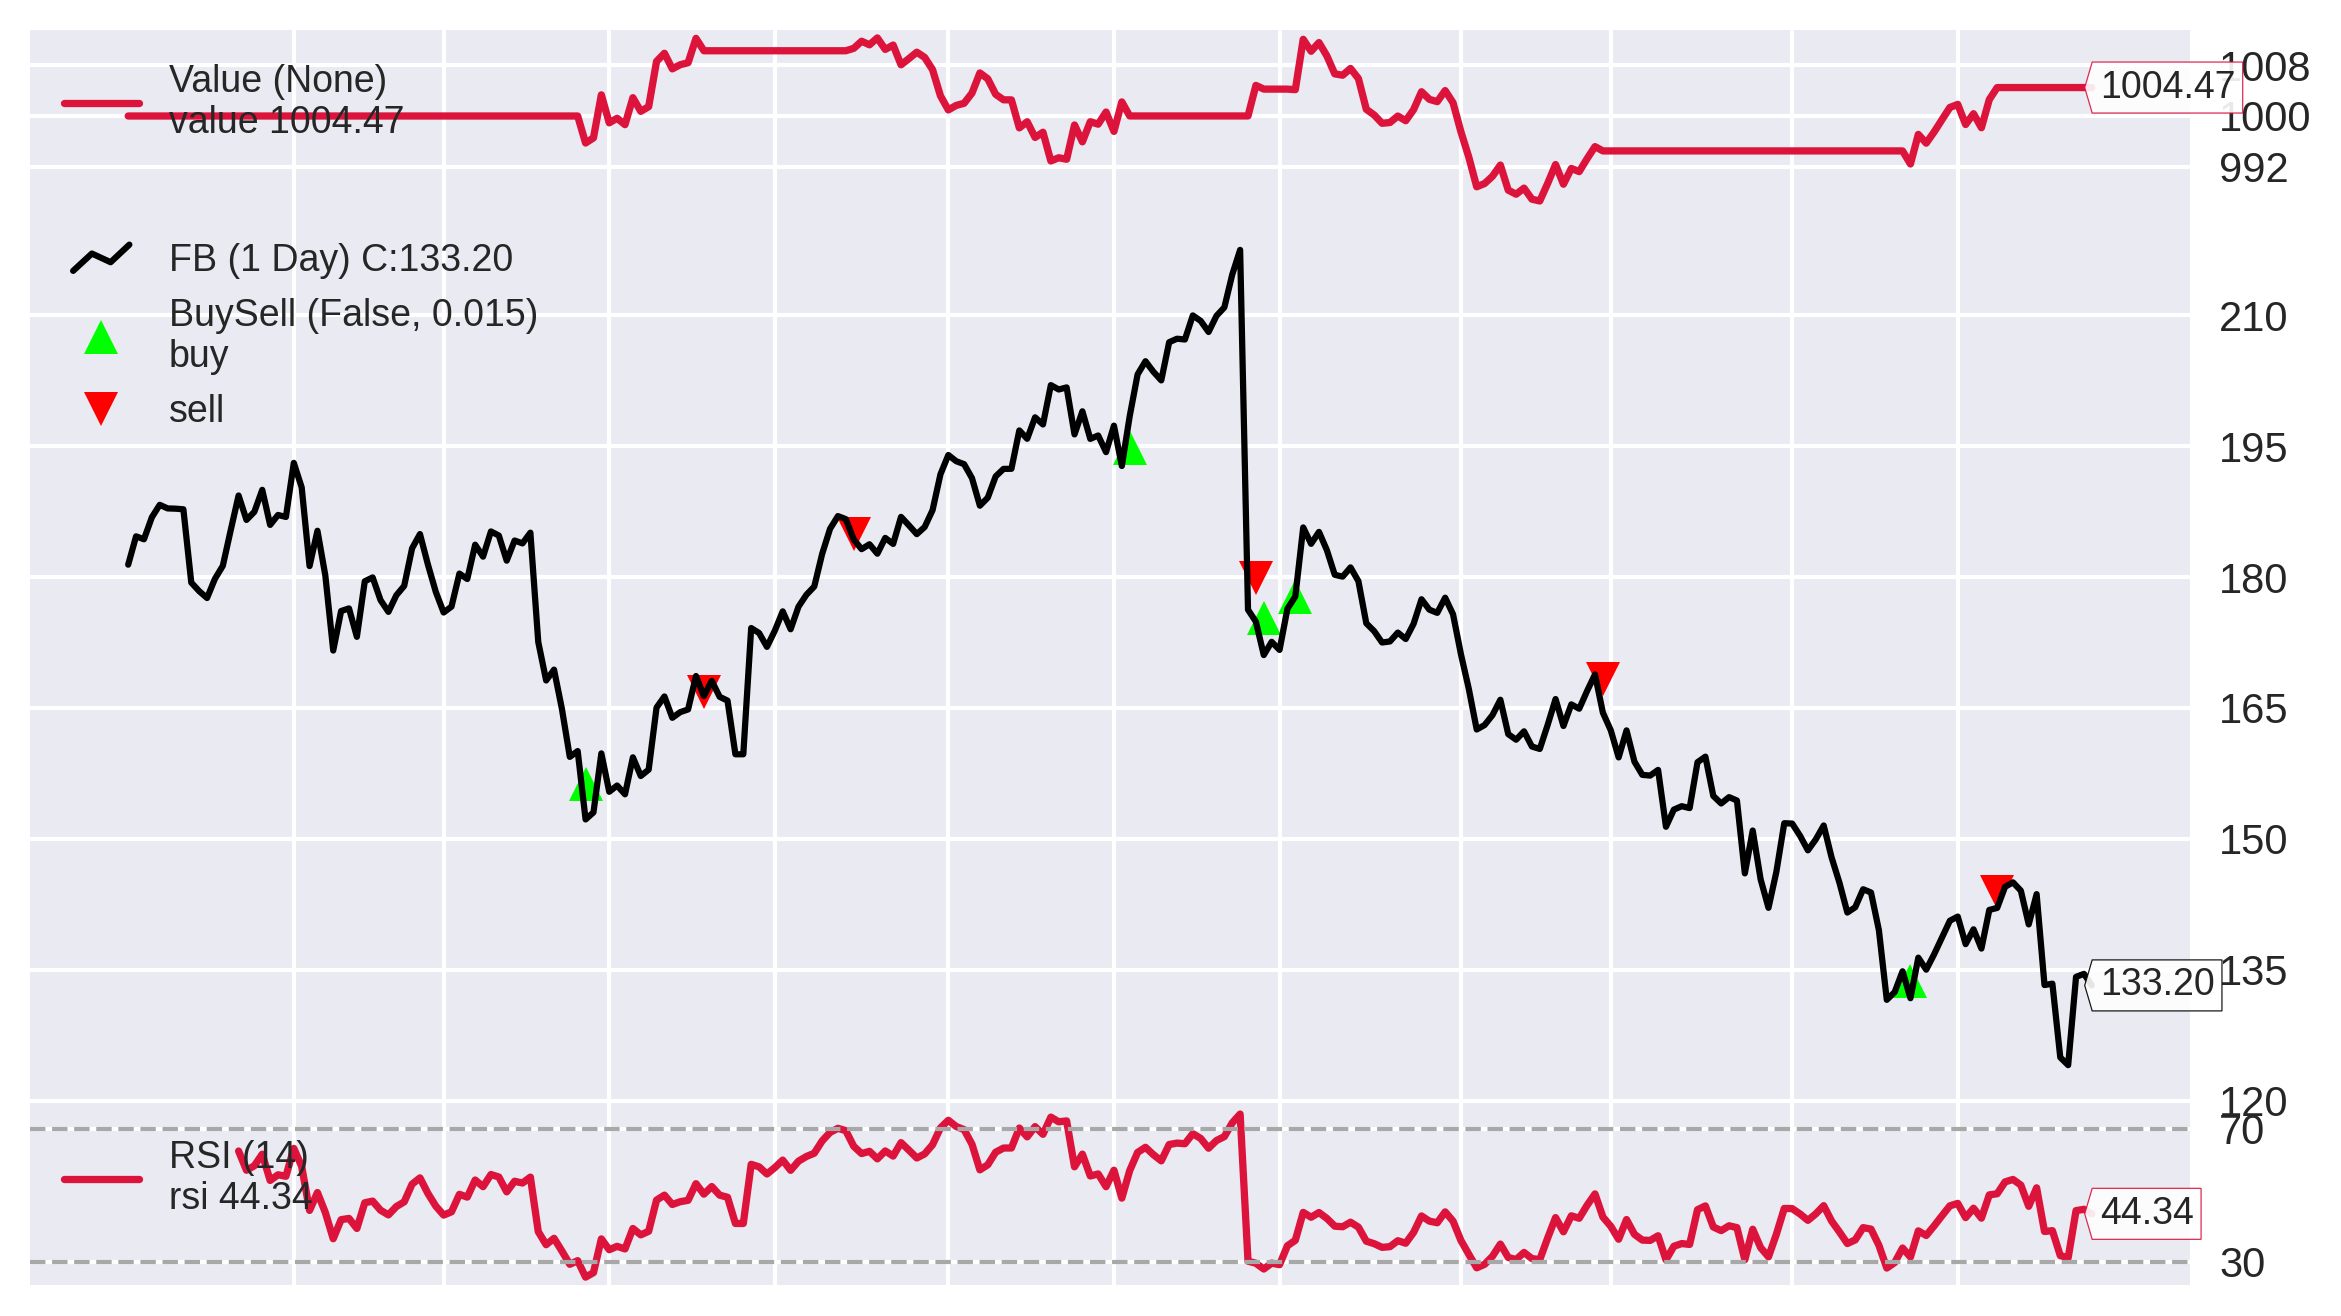

In [ ]:
cerebro.plot(iplot=True, volume=False)

## Building an Interactive Dashboard for Technical Analysis

### How to do it...

1. Import the libraries:

In [78]:
import ipywidgets as wd
from ipywidgets import interact, interact_manual
import cufflinks as cf
import pandas as pd 
import yfinance as yf
from plotly.offline import iplot, init_notebook_mode

#init_notebook_mode()

2. Define the possible values for assets and technical indicators:

In [79]:
stocks = ['TWTR', 'MSFT', 'GOOGL', 'FB', 'TSLA', 'AAPL']
indicators = ['Bollinger Bands', 'MACD', 'RSI']

3. Define a function for creating the interactive plot:

In [89]:
def ta_dashboard(asset, indicator, start_date, end_date, 
                 bb_k, bb_n, macd_fast, macd_slow, macd_signal,
                 rsi_periods, rsi_upper, rsi_lower):
    
    df = yf.download(asset, 
                     start=start_date, 
                     end=end_date,
                     progress=False,
                     auto_adjust=True)

    qf = cf.QuantFig(df, title=f'TA Dashboard - {asset}', 
                     legend='right', name=f'{asset}')
            
    if 'Bollinger Bands' in indicator: 
        qf.add_bollinger_bands(periods=bb_n, 
                               boll_std=bb_k)
    if 'MACD' in indicator: 
        qf.add_macd(fast_period=macd_fast, 
                    slow_period=macd_slow, 
                    signal_period=macd_signal)
    if 'RSI' in indicator: 
        qf.add_rsi(periods=rsi_periods, 
                   rsi_upper=rsi_upper, 
                   rsi_lower=rsi_lower, 
                   showbands=True)

    return qf.iplot(
        asFigure=True
        )

4. Define the selectors:

In [90]:
stocks_selector = wd.Dropdown(
    options=stocks, 
    value=stocks[0], 
    description='Asset'
)

indicator_selector = wd.SelectMultiple(
    description='Indicator',
    options=indicators, 
    value=[indicators[0]]
)

start_date_selector = wd.DatePicker(
    description='Start Date', 
    value=pd.to_datetime('2018-01-01'), 
    continuous_update=False
)

end_date_selector = wd.DatePicker(
    description='End Date', 
    value=pd.to_datetime('2018-12-31'), 
    continuous_update=False
)

5. Define a label and group the selectors inside a container:

In [91]:
main_selector_label = wd.Label('Main parameters', 
                               layout=wd.Layout(height='45px'))

main_selector_box = wd.VBox(children=[main_selector_label,
                                      stocks_selector,
                                      indicator_selector,
                                      start_date_selector,
                                      end_date_selector])

6. Define the secondary selectors for Bollinger Bands:

In [92]:
bb_label = wd.Label('Bollinger Bands')

n_param = wd.IntSlider(value=20, min=1, max=40, step=1, 
                       description='N:', continuous_update=False)

k_param = wd.FloatSlider(value=2, min=0.5, max=4, step=0.5, 
                         description='k:', continuous_update=False)

bollinger_box = wd.VBox(children=[bb_label, n_param, k_param])

7. Define the secondary selectors for MACD:

In [93]:
macd_label = wd.Label('MACD')

macd_fast = wd.IntSlider(value=12, min=2, max=50, step=1, 
                         description='Fast avg:', 
                         continuous_update=False)

macd_slow = wd.IntSlider(value=26, min=2, max=50, step=1, 
                         description='Slow avg:', 
                         continuous_update=False)

macd_signal = wd.IntSlider(value=9, min=2, max=50, step=1, 
                           description='MACD signal:', 
                           continuous_update=False)

macd_box = wd.VBox(children=[macd_label, macd_fast, 
                             macd_slow, macd_signal])

8. Define the secondary selectors for RSI:

In [94]:
rsi_label = wd.Label('RSI')

rsi_periods = wd.IntSlider(value=14, min=2, max=50, step=1, 
                           description='RSI periods:', 
                           continuous_update=False)

rsi_upper = wd.IntSlider(value=70, min=1, max=100, step=1, 
                         description='Upper Thr:', 
                         continuous_update=False)

rsi_lower = wd.IntSlider(value=30, min=1, max=100, step=1, 
                         description='Lower Thr:', 
                         continuous_update=False)

rsi_box = wd.VBox(children=[rsi_label, rsi_periods, 
                            rsi_upper, rsi_lower])

9. Create the labels and group the selectors into containers:

In [95]:
sec_selector_label = wd.Label('Secondary parameters', 
                              layout=wd.Layout(height='45px'))
blank_label = wd.Label('', layout=wd.Layout(height='45px'))

sec_box_1 = wd.VBox([sec_selector_label, bollinger_box, macd_box])
sec_box_2 = wd.VBox([blank_label, rsi_box])

secondary_selector_box = wd.HBox([sec_box_1, sec_box_2])

10. Group the boxes and prepare the interactive output:

In [96]:
controls_dict = {'asset':stocks_selector, 
                 'indicator':indicator_selector, 
                 'start_date':start_date_selector, 
                 'end_date':end_date_selector, 
                 'bb_k':k_param, 
                 'bb_n':n_param,
                 'macd_fast': macd_fast, 
                 'macd_slow': macd_slow, 
                 'macd_signal': macd_signal,
                 'rsi_periods': rsi_periods, 
                 'rsi_upper': rsi_upper,
                 'rsi_lower': rsi_lower}

ui = wd.HBox([main_selector_box, secondary_selector_box])
out = wd.interactive_output(ta_dashboard, controls_dict)

11. Display the dashboard:

In [97]:
display(ui, out)

Output()